In [1]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
from itertools import permutations
#!pip install ipython-autotime

In [2]:
#Upload Data and Define Parameters
leu_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Leu_S5_L001_R1_001.fastq').readlines()
ala_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Ala_S3_L001_R1_001.fastq').readlines()
gly_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Gly_S1_L001_R1_001.fastq').readlines()
phe_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Phe_S7_L001_R1_001.fastq').readlines()

leu_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/LeuNaOH_S6_L001_R1_001.fastq').readlines()
ala_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/AlaNaOH_S4_L001_R1_001.fastq').readlines()
gly_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/GlyNaOH_S2_L001_R1_001.fastq').readlines()
phe_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/PheNaOH_S8_L001_R1_001.fastq').readlines()

ctrl_8a = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/8actrl_S9_L001_R1_001.fastq').readlines()
ctrl_5b = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/5bctrl_S10_L001_R1_001.fastq').readlines()


In [3]:
#Upload Data and Define Parameters
file_type = '.fastq'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9


#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'AAAGCCTG'
#Position motif2 starts at
motif2_start = 21
#Motif2 define
motif2 = 'TAGGCAAAAGATCGGAAGAGCACACGTCT'

In [4]:
def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
    
    if file_type == '.fasta':
        high_quality = list_of_seqs[1::2]
        print('Total seqs: '+str(len(high_quality)))
    
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                trimmed.append('GCCTG'+seq[(motif_start-1)+len(motif):(motif2_start-1)]+'TAGGC')
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def rscape_format(title, num_seqs_to_analyze, top_seqs):
    #Create file for R-Scape Covariation
    f = open("/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/"+str(title)+".txt", "w")
    f.write('# STOCKHOLM 1.0\n')
    f.write('\n')
    counter = 0
    for seq in top_seqs[:num_seqs_to_analyze]:
      counter+=1
      f.write(str(counter)+'\t'+seq[0]+'\n')
    #f.write('#=GC SS_cons	(((((((((,)))))))))\n')
    f.write('//')

def make_heatmap(seqs_to_analyze):
  heatmap_data = []

  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'T' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)


  fig, ax = plt.subplots(figsize = (30,6));
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');
  im.set_clim(0,1)
  cbar = fig.colorbar(im, orientation='vertical',)
  y_label_list = ['', 'A', 'C', 'G', 'T', ''];
  ax.set_yticks(range(-1, 1+len(heatmap_data[0])));
  ax.set_yticklabels(y_label_list);
  ax.set_xticks(range(len(heatmap_data)));
  ax.set_xticklabels(range(1, len(heatmap_data)+1));
  ax.grid(False)
  plt.show()
  return heatmap_data

def enrichment(seq_half1, seq_half2):

    #Find avg counts of any left half
    frequency_dict_half1 = [(k,v) for k,v in dict(Counter(half_1)).items()]
    all_counts = []
    for element in frequency_dict_half1:
        all_counts.append(element[1])
    mean_counts_half1 = np.mean(all_counts)

    #Find avg counts of any right half
    frequency_dict_half2 = [(k,v) for k,v in dict(Counter(half_2)).items()]
    all_counts = []
    for element in frequency_dict_half2:
        all_counts.append(element[1])
    mean_counts_half2 = np.mean(all_counts)
    print('In control, half 1 of top seq has: '+str(half_1.count(seq_half1))+' counts ('+str(round(mean_counts_half1,1))+' average)')
    print('In control, half 2 of top seq has: '+str(half_2.count(seq_half2))+' counts ('+str(round(mean_counts_half2,1))+' average)')

    #Enrichment of our two halves
    enrichment_half1 = half_1.count(seq_half1)/mean_counts_half1
    enrichment_half2 = half_2.count(seq_half2)/mean_counts_half2

    #Total enrichment score is the average enrichment of both halves
    enrichment = np.mean([enrichment_half1, enrichment_half2])
    return enrichment

def get_info(aa, rna, title):
    print(title)
    print('AA ONLY:')
    aa_ctrl_processed_seqs, aa_ctrl_processed_seqs_unique = preprocess_seqs(aa)
    aa_ctrl_top_seqs = Counter(aa_ctrl_processed_seqs).most_common(100)
    print('Unique AA seqs '+str(len(aa_ctrl_processed_seqs_unique)))
    print(aa_ctrl_top_seqs[:10])
    print('RNA ONLY:')
    rna_ctrl_processed_seqs, rna_ctrl_processed_seqs_unique = preprocess_seqs(rna)
    rna_ctrl_top_seqs = Counter(rna_ctrl_processed_seqs).most_common(100)
    print('Unique RNA seqs '+str(len(rna_ctrl_processed_seqs_unique)))
    print(rna_ctrl_top_seqs[:10])
    aa_rna_no_overlap = list(filterfalse(set(rna_ctrl_processed_seqs).__contains__, aa_ctrl_processed_seqs))
    print('AA NOT RNA: '+str(round(len(aa_rna_no_overlap))))
    aa_not_rna_top_seqs = Counter(aa_rna_no_overlap).most_common(10000)
    print('Unique AA only seqs '+str(len(set(aa_rna_no_overlap))))
    top_seqs = aa_not_rna_top_seqs[:10]
    print(top_seqs)
    reads = []
    for seq in aa_not_rna_top_seqs:
        reads.append(seq[1])
    seq_half1 = top_seqs[0][0][5:-5][:6]
    seq_half2 = top_seqs[0][0][5:-5][6:]
    enrich = enrichment(seq_half1, seq_half2)
    print('Enrichment scale = '+str(enrich))
    rscape_format(title+'_rscape_1000',1000, aa_not_rna_top_seqs)
    print('R-Scape file saved')

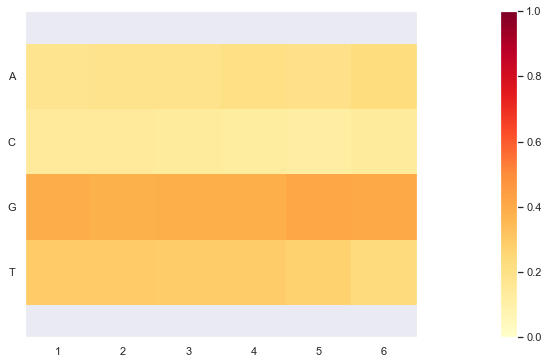

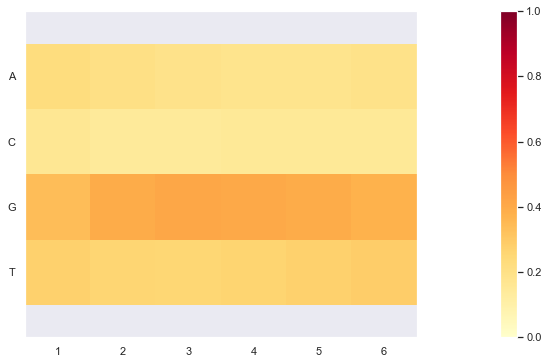

[[0.2240400175132753,
  0.16153751160735622,
  0.33799017524501745,
  0.27643229563435107],
 [0.2059525890619011,
  0.14222158783821712,
  0.3936589754733957,
  0.2581668476264861],
 [0.18796138739781917,
  0.14422470879368496,
  0.41266857730298767,
  0.2551453265055082],
 [0.1831035384193467,
  0.1498668060885896,
  0.40241721689678234,
  0.2646124385952814],
 [0.18341627547804665,
  0.14878265095176313,
  0.3933911442487655,
  0.2744099293214247],
 [0.19367725856298124,
  0.14903444437851127,
  0.3721234204773811,
  0.2851648765811264]]

In [5]:
#Find prevalence of sequences in control
#8a prevalence
motif_ctrl_1 = 'AAAGCCTG'
len_half_1 = 6
half_1 = []
for seq in ctrl_8a[1::4]:
    if motif_ctrl_1 in seq:
        sub = seq[seq.index(motif_ctrl_1)+len(motif_ctrl_1):seq.index(motif_ctrl_1)+len(motif_ctrl_1)+len_half_1]
        if len(sub) == 6:
            half_1.append(sub)

#5b prevalence
motif_ctrl_2 = 'TAGGCAAAAGATCGGAAGAGCACACGTCT'
len_half_2 = 6
half_2 = []
for seq in ctrl_5b[1::4]:
    if motif_ctrl_2 in seq:
        sub = seq[seq.index(motif_ctrl_2)-6:seq.index(motif_ctrl_2)]
        if len(sub)==6:
            half_2.append(sub)

make_heatmap(half_1)
make_heatmap(half_2)

In [6]:
get_info(gly_aa, gly_rna, 'Gly')
print('')
get_info(leu_aa, leu_rna, 'Leu')
print('')
get_info(phe_aa, phe_rna, 'Phe')
print('')
get_info(ala_aa, ala_rna, 'Ala')


Gly
AA ONLY:
Total seqs: 356811
High quality seqs: 347603
Seqs after trimming: 216113
Unique AA seqs 153628
[('GCCTGGGGGGTAGGCAATAGGC', 31), ('GCCTGGGTGGTAGGCAATAGGC', 29), ('GCCTGTTATGGGAGTAATAGGC', 28), ('GCCTGGGGGTAGGCAAATAGGC', 27), ('GCCTGATGTGGGAATGTTAGGC', 26), ('GCCTGTTTGTAGGTAGATAGGC', 26), ('GCCTGATAGTGGGGTGTTAGGC', 24), ('GCCTGATTGTAGGGGGTTAGGC', 24), ('GCCTGGATTGGGAGGTTTAGGC', 24), ('GCCTGAATGTGGGGGTTTAGGC', 24)]
RNA ONLY:
Total seqs: 574755
High quality seqs: 551138
Seqs after trimming: 332641
Unique RNA seqs 211879
[('GCCTGGTGGTAGGCAAATAGGC', 784), ('GCCTGGTAGGCAAAAGATAGGC', 739), ('GCCTGGTATTAGGCAAATAGGC', 609), ('GCCTGGGTGGTAGGCAATAGGC', 575), ('GCCTGGGGGGTAGGCAATAGGC', 525), ('GCCTGGGGGGGTAGGCATAGGC', 514), ('GCCTGGGGGGTTAGGCATAGGC', 505), ('GCCTGGGGGTAGGCAAATAGGC', 468), ('GCCTGGTGTTAGGCAAATAGGC', 449), ('GCCTGGTGTAGGCAAAATAGGC', 440)]
AA NOT RNA: 144422
Unique AA only seqs 118777
[('GCCTGATTTGGAGGAGTTAGGC', 21), ('GCCTGTAAGAGGGGTTATAGGC', 19), ('GCCTGGAATGAGGGTTTTAGG